# Setup

In [49]:
LOG_PLOT = False

In [50]:
%matplotlib notebook
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
import os
from helper import *
df = ecdc()
df_at = at()
def country_name(geoId):
    return df[df.geoId==geoId].iloc[0].countriesAndTerritories.replace('_', ' ')

print(df.columns)

Index(['dateRep', 'day', 'month', 'year', 'cases', 'deaths',
       'countriesAndTerritories', 'geoId', 'countryterritoryCode',
       'popData2019', 'continentExp',
       'Cumulative_number_for_14_days_of_COVID-19_cases_per_100000'],
      dtype='object')


## ECDC Data

In [51]:


def plot_selection(selection, roll_days=7, log=False):   
    f,ax = plt.subplots()
    ax.plot(selection.dateRep, selection['cases'].rolling(roll_days).mean(), label=f'{roll_days} day average', marker='o', markersize=4, linestyle='--')
#     ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    ax.xaxis.set_major_locator(plt.MaxNLocator(20))

    plt.xticks(rotation=45)
    ax.bar(selection.dateRep, selection['cases'],label='recorded',  alpha=0.6, color='C1')
    plt.legend(loc='best')
    if log:
        plt.yscale('log')
        
    plt.title(selection.iloc[0].countriesAndTerritories.replace('_', ' '))
    plt.tight_layout()

    return f

def plot_comparison(geoIds, roll_days=1, 
                    field='Cumulative_number_for_14_days_of_COVID-19_cases_per_100000',
                    log=False, ndays=30):
    f,ax = plt.subplots(figsize=(9,6))
    for geoId in geoIds:
        selection = select_country(geoId, ndays)
        ax.plot(selection.dateRep, selection[field], 
                label=country_name(geoId))

    ax.xaxis.set_major_locator(plt.MaxNLocator(25))
    ax.yaxis.set_major_locator(plt.MaxNLocator(10))

    plt.xticks(rotation=45)
    if log:
        plt.yscale('log')
        
    plt.legend(loc='best')
    plt.title('Cumulative number for 14 days of COVID-19 cases per 100000')
    plt.tight_layout()

def select_country(geoId, ndays=0):
    if not ndays:
        selection = df[df.geoId==geoId].sort_values(by=['year','month','day'], ascending=True)
    else:
        selection = df[df.geoId==geoId].sort_values(by=['year','month','day'], ascending=True).tail(ndays)
        
    return selection

def plot_country(geoId, **kwargs):
    return plot_selection(select_country(geoId), **kwargs)
    


## Austria - from Gesundheitsminesterium

In [52]:

def plot_Austria(roll_days=7, log=False):
    df = at()
    f,ax = plt.subplots()
    ax.plot(df.time, df['tägliche Erkrankungen'].rolling(roll_days).mean(), label=f'{roll_days} day average', marker='o', markersize=4, linestyle='--')
    ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.xticks(rotation=45)
    ax.bar(df.time, df['tägliche Erkrankungen'],label='recorded',  alpha=0.6, color='C1')
    plt.legend(loc='best')
    plt.title('Positive COVID tests')
    if log:
        plt.yscale('log')
    plt.tight_layout()
    return f


## DF Subsets

In [53]:
EU = df[df.continentExp=='Europe']
AMERICA = df[(df.continentExp=='America')]


# Overview

<IPython.core.display.Javascript object>


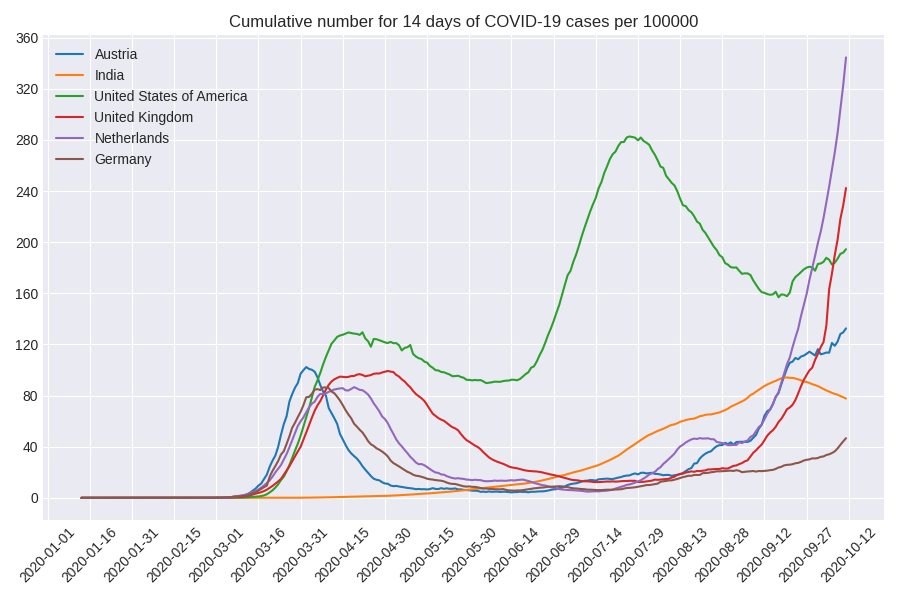

cases                                     \
                         rolling_avg                        last_5_days   
countriesAndTerritories                                                   
India                          72062  72049, 78524, 70496, 73272, 74383   
United_States_of_America       48000  43062, 48182, 56800, 58082, 54271   
United_Kingdom                 15832  14542, 14162, 17540, 13864, 15165   
Netherlands                     5190       4517, 4979, 5813, 5959, 6493   
Germany                         3375       2828, 4058, 4516, 4721, 3483   
Austria                          952          549, 947, 1221, 1181, 901   

                                 deaths                              \
                            max     sum last_7_days_sum rolling_avg   
countriesAndTerritories                                               
India                     97894  108334            6552         936   
United_States_of_America  78427  214377            4983         712   
United_Kingdom            22961   42760             443          63   
Netherlands                6493    6558             118          17   
Germany                    6294    9615              86          12   
Austria                    1268     858              49           7   

                                                          \
                                       last_5_days   max   
countriesAndTerritories                                    
India                      986, 971, 964, 926, 918  2003   
United_States_of_America  717, 892, 972, 1014, 590  4928   
United_Kingdom                  76, 70, 77, 87, 81  1224   
Netherlands                     21, 36, 13, 13, 23   234   
Germany                         16, 16, 11, 15, 11   315   
Austria                             22, 4, 9, 4, 1    31   

                         Cumulative_number_for_14_days_of_COVID-19_cases_per_100000  \
                                                                             latest   
countriesAndTerritories                                                               
India                                                             77.668341           
United_States_of_America                                         194.535779           
United_Kingdom                                                   242.421607           
Netherlands                                                      344.638573           
Germany                                                           46.644624           
Austria                                                          132.580408           

                                      
                                 max  
countriesAndTerritories               
India                      94.173835  
United_States_of_America  282.723242  
United_Kingdom            242.421607  
Netherlands               344.638573  
Germany                    86.358323  
Austria                   132.580408

In [55]:
# countries = ['AT', 'IN', 'US', 'UK', 'DE', 'NL', 'FR',  'IT', 'ES','EL' ]
countries = ('AT', 'IN', 'US', 'UK', 'NL', 'DE')
SELECTION =  df[df.geoId.isin(countries)]

plot_comparison(countries, log=False, ndays=500)
overview(SELECTION, compact=False)

## Sweden and the world

<IPython.core.display.Javascript object>


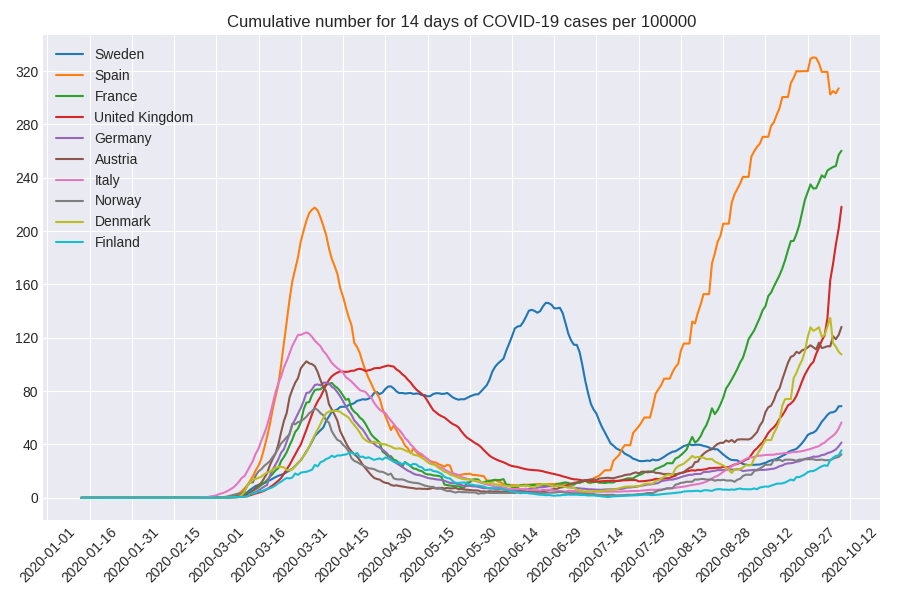

In [7]:
countries = ('SE', 'ES','FR','UK','DE','AT','IT','NO','DK','FI')
plot_comparison(countries, log=False, ndays=500)


## Most cases in the last 7 days

### Europe

In [56]:
overview(EU, compact=True).head(5)



cases               deaths                  \
                        rolling_avg latest    max    sum last_7_days_sum   
countriesAndTerritories                                                    
France                        16035  26896  26896  32684             486   
United_Kingdom                15832  15165  22961  42760             443   
Russia                        11512  12846  12846  22454            1203   
Spain                         10169      0  31785  32929             843   
Netherlands                    5190   6493   6493   6558             118   

                                                  
                        rolling_avg latest   max  
countriesAndTerritories                           
France                           69     54  2004  
United_Kingdom                   63     81  1224  
Russia                          172    197   312  
Spain                           120      0  1179  
Netherlands                      17     23   234

### America

In [57]:
overview(AMERICA).head(5)

cases                deaths                  \
                         rolling_avg latest    max     sum last_7_days_sum   
countriesAndTerritories                                                      
United_States_of_America       48000  54271  78427  214377            4983   
Brazil                         25115  26749  69074  150198            4211   
Argentina                      13297  12428  17213   23581            2786   
Mexico                          8054   4577  30468   83642            4762   
Colombia                        7800   8447  13056   27660            1104   

                                                   
                         rolling_avg latest   max  
countriesAndTerritories                            
United_States_of_America         712    590  4928  
Brazil                           602    559  1595  
Argentina                        398    356  3351  
Mexico                           680    135  3013  
Colombia                         158    165   400

### World

In [58]:
overview(df).head(5)

cases                deaths                  \
                         rolling_avg latest    max     sum last_7_days_sum   
countriesAndTerritories                                                      
India                          72062  74383  97894  108334            6552   
United_States_of_America       48000  54271  78427  214377            4983   
Brazil                         25115  26749  69074  150198            4211   
France                         16035  26896  26896   32684             486   
United_Kingdom                 15832  15165  22961   42760             443   

                                                   
                         rolling_avg latest   max  
countriesAndTerritories                            
India                            936    918  2003  
United_States_of_America         712    590  4928  
Brazil                           602    559  1595  
France                            69     54  2004  
United_Kingdom                    63     81  1224

## Lowset number of new cases in the last 7 days

### Europe*

\*among countries with population of at least 1 million

In [59]:
overview(EU[EU.popData2019>1*10**7], compact=False).tail(5)

cases                                      \
                        rolling_avg                   last_5_days   max   
countriesAndTerritories                                                   
Romania                        2620  2121, 2958, 3130, 3186, 3517  3517   
Portugal                       1047    427, 944, 1278, 1394, 1646  1646   
Sweden                          401           786, 831, 657, 0, 0  1698   
Greece                          352       399, 406, 434, 391, 306   460   
Azerbaijan                      170       143, 182, 191, 215, 233   590   

                        deaths                              \
                           sum last_7_days_sum rolling_avg   
countriesAndTerritories                                      
Romania                   5358             411          59   
Portugal                  2067              72          10   
Sweden                    5894               5           1   
Greece                     436              31           4   
Azerbaijan                 608              13           2   

                                                  \
                                last_5_days  max   
countriesAndTerritories                            
Romania                  73, 82, 44, 52, 59  101   
Portugal                   14, 8, 10, 12, 5   60   
Sweden                        1, 0, 0, 0, 0  115   
Greece                        3, 4, 6, 1, 5    9   
Azerbaijan                    2, 2, 1, 2, 3   13   

                        Cumulative_number_for_14_days_of_COVID-19_cases_per_100000  \
                                                                            latest   
countriesAndTerritories                                                              
Romania                                                         160.540150           
Portugal                                                        122.949021           
Sweden                                                           72.462033           
Greece                                                           45.223136           
Azerbaijan                                                       18.481807           

                                     
                                max  
countriesAndTerritories              
Romania                  160.540150  
Portugal                 122.949021  
Sweden                   146.155715  
Greece                    45.307055  
Azerbaijan                76.226256

### America*

\*among countries with population of at least 10 million

In [60]:
overview(AMERICA[AMERICA.popData2019>1*10**7]).tail(5)


cases              deaths                  \
                        rolling_avg latest   max    sum last_7_days_sum   
countriesAndTerritories                                                   
Dominican_Republic              584    557  2147   2167              39   
Guatemala                       542    609  4233   3365              80   
Bolivia                         271    237  2687   8292             219   
Cuba                             24      5    93    123               1   
Haiti                             7      6   284    230               1   

                                                  
                        rolling_avg latest   max  
countriesAndTerritories                           
Dominican_Republic                6      2    39  
Guatemala                        11      9    74  
Bolivia                          31     30  1610  
Cuba                              0      0     6  
Haiti                             0      0    12

### World*
\*among countries with population of at least 10 million

In [61]:
overview( df[df.popData2019>1*10**7]).tail(5)


cases             deaths                  \
                            rolling_avg latest  max    sum last_7_days_sum   
countriesAndTerritories                                                      
Taiwan                                1      0   31      7               0   
Cambodia                              1      0   35      0               0   
Burundi                               1      2   40      1               0   
United_Republic_of_Tanzania           0      0  174     21               0   
Niger                                 0      0   69     69               0   

                                                    
                            rolling_avg latest max  
countriesAndTerritories                             
Taiwan                                0      0   3  
Cambodia                              0      0   0  
Burundi                               0      0   1  
United_Republic_of_Tanzania           0      0   6  
Niger                                 0      0   5

# Austria
Compare ECDC data with Gesundheitsminesterium Data

## Plots

<IPython.core.display.Javascript object>


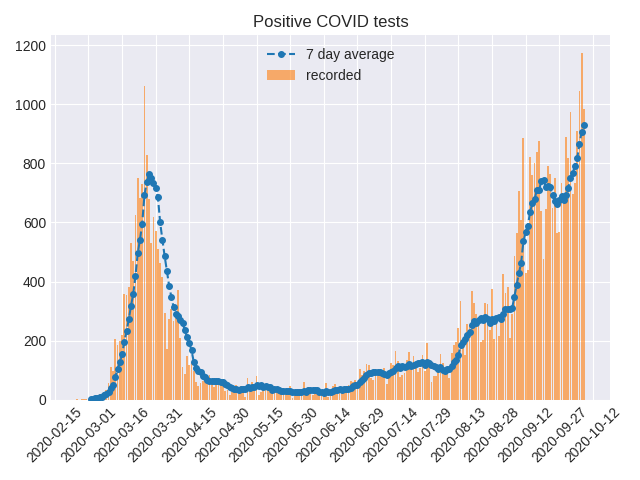

<IPython.core.display.Javascript object>


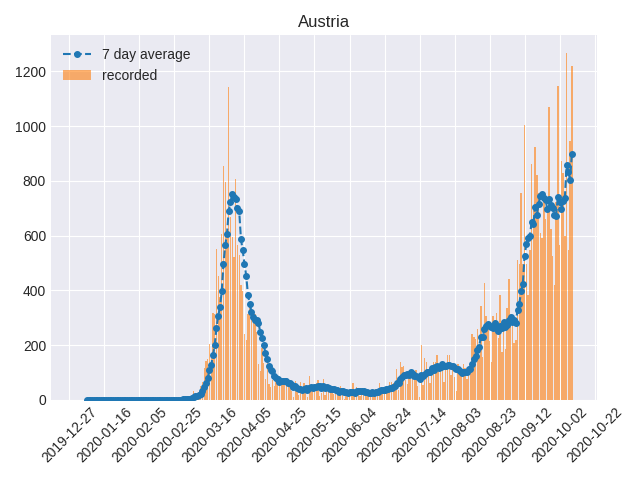

In [33]:
plot_Austria();
plot_country('AT', log=LOG_PLOT);

### Weekday bias

<IPython.core.display.Javascript object>


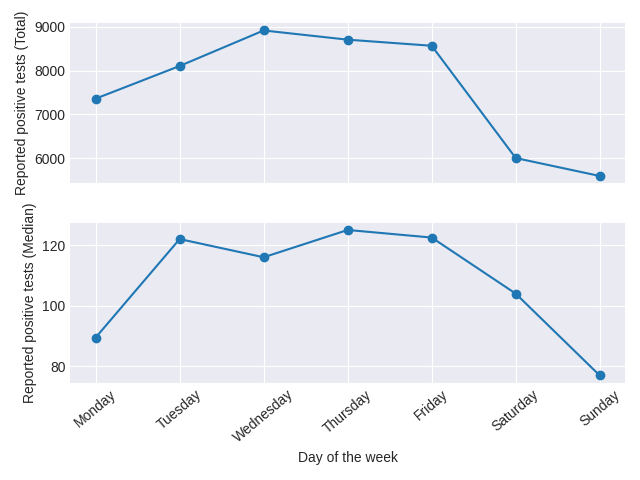

In [34]:
f, ax = plt.subplots(nrows=2, sharex=True)
df_at.groupby(['weekday']).sum()['tägliche Erkrankungen'].plot(ax=ax[0], marker='o')
ax[0].set_ylabel('Reported positive tests (Total)')
df_at.groupby(['weekday']).median()['tägliche Erkrankungen'].plot(ax=ax[1], marker='o')
ax[1].set_ylabel('Reported positive tests (Median)')
ax[1].set_xlabel('Day of the week')
ax[1].set_xticks([0,1,2,3,4,5,6])
ax[1].set_xticklabels(WEEKDAYS, rotation=40)
plt.tight_layout()

# India

<IPython.core.display.Javascript object>


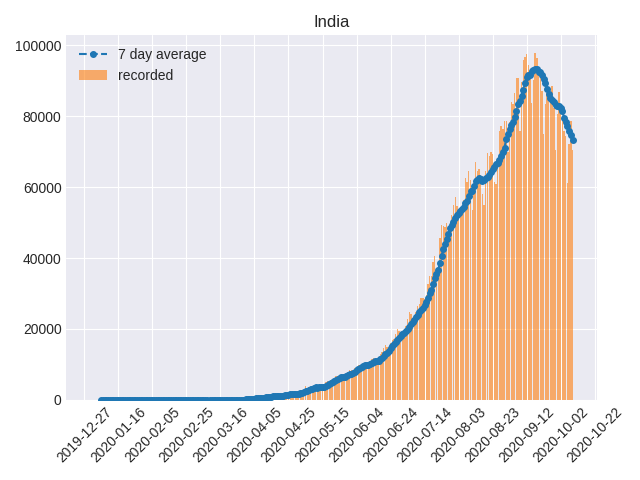

In [35]:
plot_country('IN', log=LOG_PLOT);

# USA

<IPython.core.display.Javascript object>


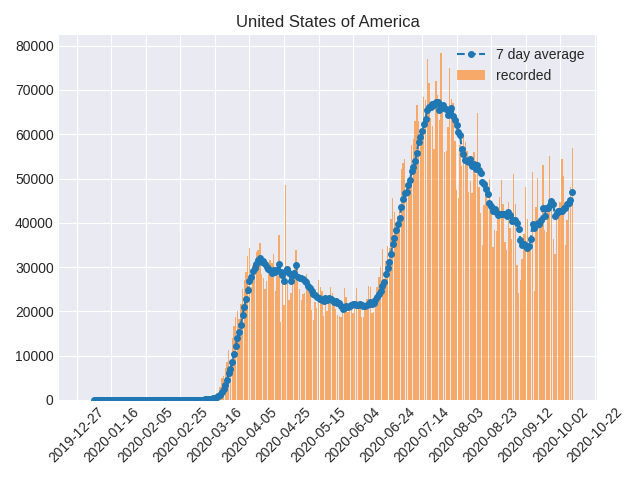

In [36]:
plot_country('US', log=LOG_PLOT);


# Germany

<IPython.core.display.Javascript object>


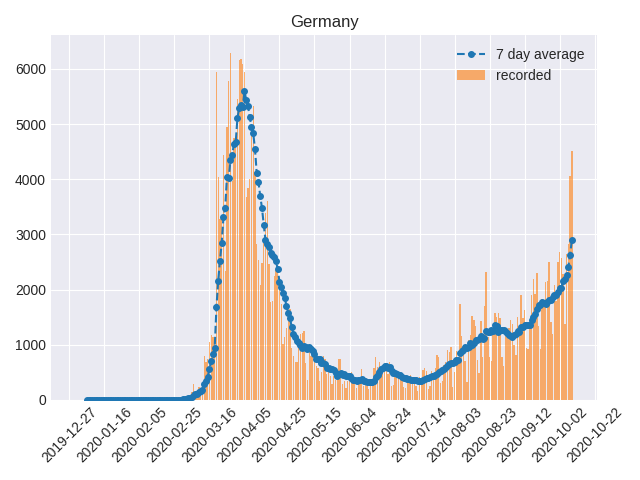

In [37]:
plot_country('DE', log=LOG_PLOT);

## UK

<IPython.core.display.Javascript object>


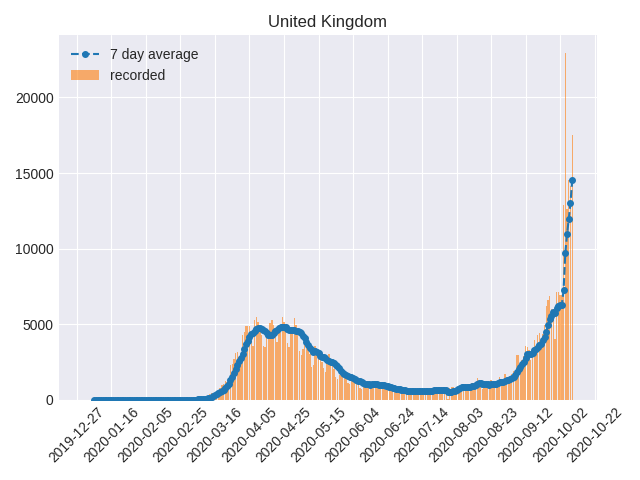

In [38]:
plot_country('UK', log=LOG_PLOT);

# China

<IPython.core.display.Javascript object>


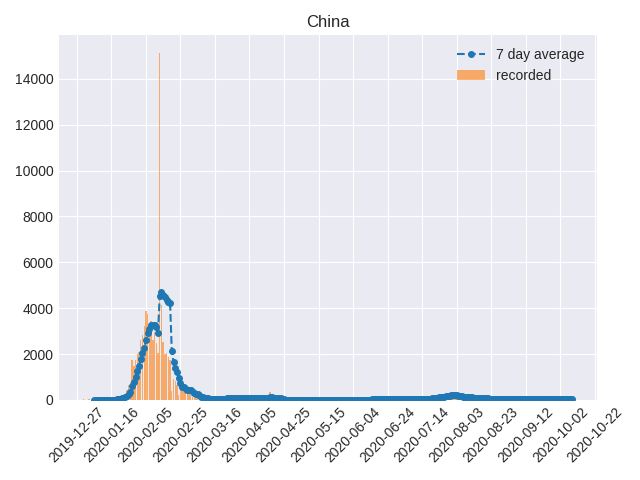

In [39]:
plot_country('CN', log=LOG_PLOT);


# Commit and Push

In [40]:
%cd Documents/code/covid19/
now = datetime.now()
commit_message = "Last run on " + now.strftime('%Y-%m-%d %H:%M')
commit_message
! echo $commit_message > commit_message.txt
! git add .
! git commit -F commit_message.txt
! git push


[Errno 2] No such file or directory: 'Documents/code/covid19/'
/home/gythaogg/Documents/code/covid19/notebooks
[feature/angular 7dae54a] Last run on 2020-10-09 17:06
 3 files changed, 478 insertions(+), 198 deletions(-)
Enumerating objects: 13, done.
Counting objects: 100% (12/12), done.
Delta compression using up to 16 threads
Compressing objects: 100% (7/7), done.
Writing objects: 100% (7/7), 197.59 KiB | 3.80 MiB/s, done.
Total 7 (delta 6), reused 0 (delta 0)
remote: Resolving deltas: 100% (6/6), completed with 5 local objects.
To github.com:gythaogg/covid19.git
   05df39b..7dae54a  feature/angular -> feature/angular


In [41]:
! git push --set-upstream origin feature/angular


Branch 'feature/angular' set up to track remote branch 'feature/angular' from 'origin'.
Everything up-to-date
